In [1]:
import torch
import torch.nn.functional as NF

import mitsuba
mitsuba.set_variant('cuda_ad_rgb')

import numpy as np
from scipy.spatial.transform import Rotation

import os

# our reconstruction in customized mitsuba BSDF
from fipt_bsdf import FIPTBSDF

from tqdm import tqdm
import matplotlib.pyplot as plt

# disable for customized BSDF to work
import drjit as dr
dr.set_flag(dr.JitFlag.VCallRecord, False)
dr.set_flag(dr.JitFlag.LoopRecord, False)

## File path

In [2]:
# brdf file
brdf_path = '../checkpoints/livingroom/cluster_part.ckpt'
# emission file
emitter_path = '../outputs/livingroom/'

# dataset folder
dataset_path = '/proj/users/xlv/lvxin/fipt/data/livingroom'

# camera pose path in Bx2x3: 
# [[camera_position,euler_anger_xyz],...]
pose_path = '/proj/users/xlv/lvxin/fipt/data/livingroom/train.npy'

# cuda device
device = torch.device(0)

## Read some pose

In [3]:
blender_pose = np.load(pose_path)
coord_conv = [0,2,1]
mitsuba_pose = []
for i,pose in enumerate(blender_pose):
    Rs = Rotation.from_euler('xyz',pose[1]).as_matrix()
    # coordinate convention
    Rs[1] = -Rs[1]
    Rs = Rs[coord_conv]
    Rs[:,2] = - Rs[:,2]
    Rs[:,0] *= -1
    
    ts = pose[0]
    ts[1] = -ts[1]
    ts = ts[coord_conv]
    mitsuba_pose.append(np.concatenate([Rs,ts.reshape(3,1)],-1))

## Edit Mitsuba file for relight and object insertion

In [4]:
img_hw = (320,640)
scene = mitsuba.load_dict({
    'type': 'scene',
    'PerspectiveCamera':   {
        'type': 'perspective',
        'fov': 60,
        "film": {
                "type": "hdrfilm",
                "width": img_hw[1],
                "height": img_hw[0],
                "rfilter": {"type": "box"}
        }
    },
    'Integrator': {
        'type':'path',
        'max_depth': 7
    },
    
    # original scene
    'main_scene': {
        'type': 'obj',
        'filename': os.path.join(dataset_path,'scene.obj'),
        'bsdf': {
            'type': 'twosided',
            'fipt_bsdf': {
                'type':'fipt',
                'emitter_path': emitter_path,
                'brdf_path': brdf_path
            }
        },
    },
    
    # add whatever you want
    'sphere_1': {
        'type': 'sphere',
        'to_world': mitsuba.ScalarTransform4f\
                      # .translate([-0.1, 2.2,0.0])\
                        .translate([-1.1, 3.2,2.0])\
                        .scale([0.192017,0.192017,0.192017]),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [0., 0., 0.]
            }
        },
        'emitter': {
            'type': 'area',
            'radiance': {
                'type': 'rgb',
                # 'value': [25.5/2.5,24.5/2.5,18.2/2.5],
                'value': [100,100,100],
            }
        }
    },
})

In [5]:
# pose_id = 1 # kitchen
pose_id = 15 #livingroom
spp = 1024
SPP = 32
seed = 0

In [6]:
# update pose
pose = mitsuba_pose[pose_id]
params = mitsuba.traverse(scene)
params['PerspectiveCamera.to_world'] = mitsuba.Transform4f.look_at(origin=pose[:3,3], target=pose[:3,3]+pose[:3,2], up=pose[:3,1])
params.update()


# batched process
img = torch.zeros(*img_hw,3)
for _ in tqdm(range(spp//SPP)):
    img_ = mitsuba.render(scene,spp=SPP,seed=seed).torch().cpu()
    img_[img_.isnan()] = 0
    img += img_
    seed += 1
img /= (spp//SPP)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:35<00:00,  1.10s/it]


## Visualize rendering results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

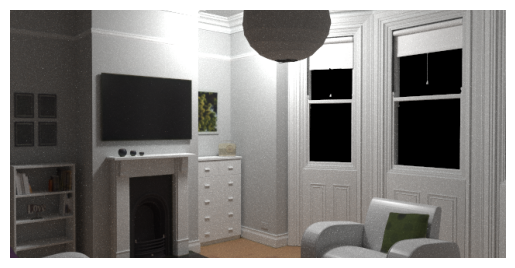

In [8]:
import cv2
plt.imshow(img**(1/2.2))
plt.axis('off')
img_ = img.cpu().numpy()
img_ = (img_**(1/2.2)
img_ = np.clip(img_,0,1)
img_ = ()*255).astype(np.uint8)
img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2BGR)
# print(img_)
# cv2.imwrite('fipt_relight.png',img**(1/2.2))
cv2.imwrite('cluster_relight_livingroom.png',img_)